# Households Living in Regional Growth Centers

In [1]:
current_run_name = 'soundcast_2014'

scen1_loc = r'S:\brice\soundcast_2040_feb17_17'
scen2_loc = r'S:\Stefan\soundcast_10peak_5offpeak'

scen1_name = '2040 no tolls'
scen2_name = '2040 10-5'

In [2]:
import os
import pandas as pd
import h5py
%matplotlib inline

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
table_list = ['Trip','Household']

main_centers = ['Bellevue','Redmond Downtown','Seattle Downtown',
               'Seattle First Hill/Capitol Hill','Seattle Northgate']

In [4]:
labels = pd.read_csv(r'../../../scripts/summarize/inputs/calibration/variable_labels.csv')
rgc_lookup = pd.read_csv(r'../../../scripts/summarize/inputs/rgc_taz.csv')

In [5]:
def h5_to_df(h5file, table_list, name=False):
    """
    Load h5-formatted data based on a table list. Assumes heirarchy of a set of tables.
    """
    output_dict = {}
    
    for table in table_list:
        df = pd.DataFrame()
        for field in h5file[table].keys():
            df[field] = h5file[table][field][:]
            
        output_dict[table] = df
    
    if name:
        output_dict['name'] = name
    
    return output_dict

In [6]:
def apply_lables(h5data):
    '''
    Replace daysim formatted values with human readable lablels.
    '''
    for table in table_list:
        df = labels[labels['table'] == table]
        for field in df['field'].unique():
            newdf = df[df['field'] == field]
            local_series = pd.Series(newdf['text'].values, index=newdf['value'])
            h5data[table][field] = h5data[table][field].map(local_series)
    
    return h5data

In [7]:
# Load data
all_results = {}

for run_loc, run_name in {r'..\..\..\outputs\daysim_outputs.h5':current_run_name,
                         scen1_loc+r'\outputs\daysim_outputs.h5':scen1_name,
                         scen2_loc+r'\outputs\daysim_outputs.h5':scen2_name}.iteritems():
    print run_name
    all_results[run_name] = apply_lables(h5_to_df(h5py.File(run_loc), table_list=table_list, name=run_name))

2040 10-5
soundcast_2014
2040 no tolls


In [8]:
trip_fields = ['mode','dpurp','travdist','hhno','trexpfac','dorp']

results_df = pd.DataFrame()
vmt_df = pd.DataFrame()
hh_df = pd.DataFrame()

for scen, values in all_results.iteritems():

    # Add home location to trip fields
    df = pd.merge(all_results[scen]['Trip'][trip_fields], 
                  all_results[scen]['Household'][['hhtaz','hhno']], on='hhno')

    # Add geography to hhtaz
    df = pd.merge(df, rgc_lookup, left_on='hhtaz', right_on='taz')

    # export for vmt analysis
    df['source'] = scen
    vmt_df = vmt_df.append(df)
    
    # Export household totals for VMT/capita
    hh_df_init = all_results[scen]['Household'][['hhtaz','hhexpfac','hhsize']]
    hh_df_init = pd.merge(hh_df_init, rgc_lookup, left_on='hhtaz', right_on='taz')
    hh_df_init['source'] = scen
    hh_df = hh_df.append(hh_df_init)

    # # Pivot by mode and center
    df = pd.pivot_table(df, index='mode', columns='center', values='trexpfac', aggfunc='sum')

    # Calculate shares
    df = df/df.sum()
    df.loc['Total'] = (df/df.sum()).sum()
    
    df['source'] = scen
    
    results_df = results_df.append(df)

# VMT/Capita
----

In [9]:
# Total households by RGC
hh_df['tot_persons'] = hh_df['hhsize']*hh_df['hhexpfac']
df = pd.DataFrame(hh_df.groupby(['center','source']).sum()['tot_persons'])
df_hh = df.reset_index()

# Total VMT by RGC
df = vmt_df[vmt_df['dorp'] == 1]
df['tot_vmt'] = df['travdist']*df['trexpfac']
df = pd.DataFrame(df.groupby(['center','source']).sum()['tot_vmt'])
df.reset_index(drop=True)
df.columns=['VMT']
df = df.reset_index()

# Merge together and calculate VMT/person
df = pd.merge(df,df_hh)
df = pd.pivot_table(df, index='center', columns='source', aggfunc='sum')
df = df['VMT']/df['tot_persons']

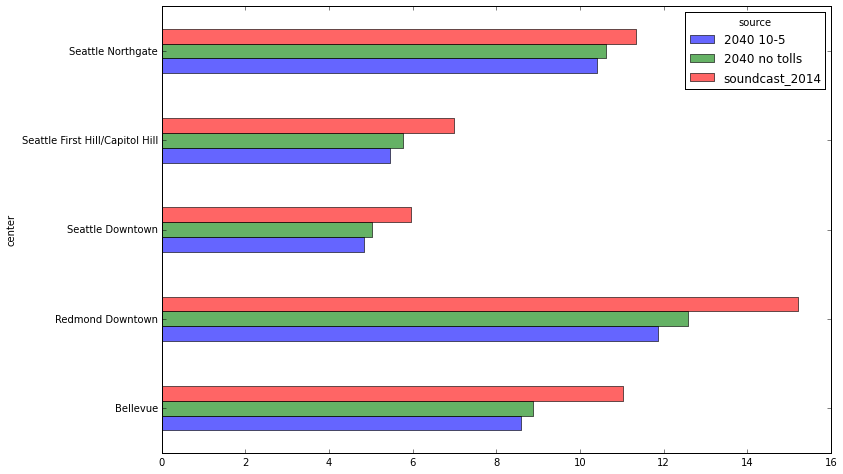

In [10]:
main_results_df = df.loc[[i for i in df.index if i in main_centers]]
df = main_results_df

df.plot(kind='barh', alpha=0.6, figsize=(12,8))

In [11]:
main_results_df

source,2040 10-5,2040 no tolls,soundcast_2014
center,,,
Bellevue,8.583500,8.877287,11.027689
Redmond Downtown,11.874104,12.588714,15.204784
Seattle Downtown,4.839861,5.037033,5.970010
Seattle First Hill/Capitol Hill,5.468503,5.772275,6.993011
Seattle Northgate,10.405389,10.616462,11.331251


# Mode Share
----


In [12]:
main_results_df = results_df[[i for i in results_df.columns if i in main_centers]+['source']]

## SOV

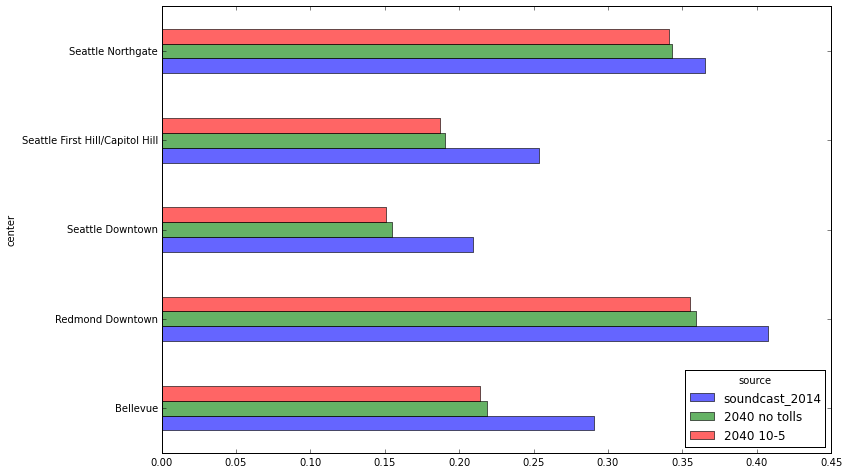

In [13]:
df = main_results_df
df['mode'] = df.index
mode = 'SOV'

df = df[df['mode'] == mode].T
df.columns = df.loc['source']
df.drop(['mode','source'],axis=0,inplace=True)
df.plot(kind='barh', alpha=0.6, figsize=(12,8))

In [14]:
df

source,soundcast_2014,2040 no tolls,2040 10-5
center,,,
Bellevue,0.290396,0.218404,0.213783
Redmond Downtown,0.40755,0.359183,0.355188
Seattle Downtown,0.209218,0.154658,0.150647
Seattle First Hill/Capitol Hill,0.2534,0.190834,0.186992
Seattle Northgate,0.365068,0.343018,0.340728


## Transit

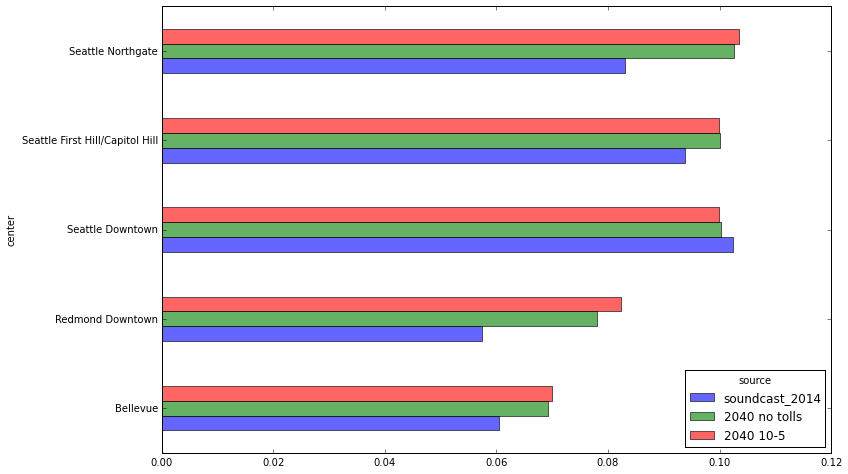

In [15]:
mode = 'Transit'
df = main_results_df
df = df[df['mode'] == mode].T
df.columns = df.loc['source']
df.drop(['mode','source'],axis=0,inplace=True)
df.plot(kind='barh', alpha=0.6, figsize=(12,8))

In [16]:
df

source,soundcast_2014,2040 no tolls,2040 10-5
center,,,
Bellevue,0.0605284,0.0691773,0.069889
Redmond Downtown,0.0575125,0.0779805,0.0823857
Seattle Downtown,0.102359,0.100283,0.0998311
Seattle First Hill/Capitol Hill,0.0938617,0.100014,0.0998632
Seattle Northgate,0.0829738,0.102519,0.103473


## Walk

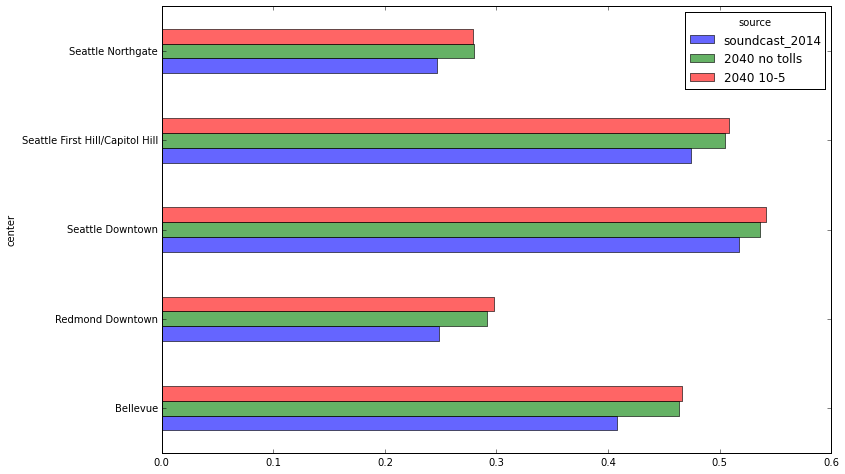

In [17]:
mode = 'Walk'
df = main_results_df
df = df[df['mode'] == mode].T
df.columns = df.loc['source']
df.drop(['mode','source'],axis=0,inplace=True)
df.plot(kind='barh', alpha=0.6, figsize=(12,8))

In [18]:
df

source,soundcast_2014,2040 no tolls,2040 10-5
center,,,
Bellevue,0.408527,0.463824,0.466584
Redmond Downtown,0.248926,0.291958,0.298192
Seattle Downtown,0.517257,0.536131,0.54154
Seattle First Hill/Capitol Hill,0.474718,0.505287,0.508792
Seattle Northgate,0.24666,0.28007,0.279507


## Bike

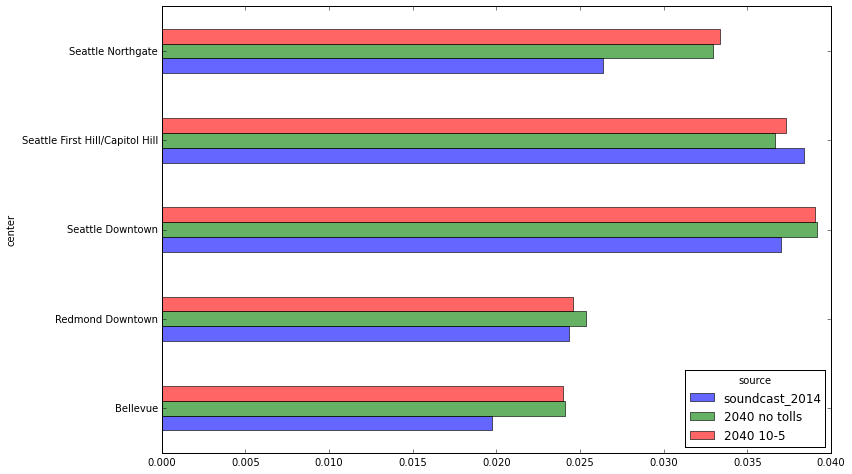

In [19]:
mode = 'Bike'
df = main_results_df
df = df[df['mode'] == mode].T
df.columns = df.loc['source']
df.drop(['mode','source'],axis=0,inplace=True)
df.plot(kind='barh', alpha=0.6, figsize=(12,8))

In [20]:
df

source,soundcast_2014,2040 no tolls,2040 10-5
center,,,
Bellevue,0.0197528,0.0241054,0.023999
Redmond Downtown,0.0243254,0.0253808,0.0245667
Seattle Downtown,0.0370313,0.0391788,0.0390294
Seattle First Hill/Capitol Hill,0.0383952,0.0366293,0.0372869
Seattle Northgate,0.0263874,0.0329347,0.0333783
